In [2]:
import os
from torch.utils.data import Dataset, DataLoader
import re
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
from lib.depth_net import DepthV3
from lib.loss_depth import L2Loss, GradientLoss, NormalLoss, BerHu
from torch import optim
import time
import torch

In [3]:
class FaceDepthDataset(Dataset):
    def __init__(self, depth_root, rgb_root, scene_root, data_type='train'):
        start = 1
        end = 69   
        start_scene = 1
        end_scene = 10
        
        if data_type == "val":
            start = 70
            end = 84
            start_scene = 11
            end_scene = 12
            
        if data_type == "test":
            start = 85
            end = 100
            start_scene = 13
            end_scene = 14
            
        self.depth_file_paths = []
        self.rgb_file_paths = []
        count = 0
        for person in os.listdir(depth_root):
            if int(person) >= start and int(person) <= end:
                depth_folder = os.path.join(depth_root, person)
                for img in os.listdir(depth_folder):
                    frame_number_regex = re.search('frame_(.*)_face', img)
                    if frame_number_regex:
                        count += 1
                        if count % 5 == 0:
                            frame_number = frame_number_regex.group(1)
                            self.depth_file_paths.append(os.path.join(depth_root, 
                                                                 person, 
                                                                 "frame_%s_face_depth.png" % frame_number))
                            self.rgb_file_paths.append(os.path.join(rgb_root, 
                                                               person, 
                                                                 "frame_%s_face_rgb.png" % frame_number))
                            
        for scene in os.listdir(scene_root):
            if ".ipynb" not in scene:
                scene_number_regex = re.search('scene_(.*)', scene)
                if scene_number_regex:
                    scene_number = int(scene_number_regex.group(1))
                    if scene_number >= start_scene and scene_number <= end_scene:
                        if scene_number < 10:
                            scene_folder = "scene_0" + str(scene_number)
                        else:
                            scene_folder = "scene_" + str(scene_number)
                        
                        for img_path in os.listdir(os.path.join(scene_root, scene_folder)):
                            if "color" in img_path:
                                img_regex = re.search('(.*)-color', img_path)
                                if img_regex:
                                    img_num = img_regex.group(1)
                                    depth_img_path = os.path.join(scene_root, scene_folder, img_num + "-depth.png") 
                                    rgb_img_path = os.path.join(scene_root, scene_folder, img_num + "-color.png") 
                                    self.depth_file_paths.append(depth_img_path)
                                    self.rgb_file_paths.append(rgb_img_path)
      
                    
    def __len__(self):
        return len(self.depth_file_paths)
    
    def __getitem__(self, idx):
        depth_img = Image.open(self.depth_file_paths[idx])
        rgb_img = Image.open(self.rgb_file_paths[idx])

        rgb_img = transforms.Compose([
            transforms.ColorJitter([0.6, 1.4], [0.6, 1.4], [0.6, 1.4])
        ])(rgb_img)
        
        
        rgb_img = TF.resize(rgb_img, 100)
        rgb_img = TF.center_crop(rgb_img, 100)
        
        depth_img = TF.resize(depth_img, 100)
        depth_img = TF.center_crop(depth_img, 100)
        
        
        # Random horizontal flip
        if random.random() > 0.5:
            depth_img = TF.hflip(depth_img)
            rgb_img = TF.hflip(rgb_img)
        
        choice = random.randint(0, 3)
        depth_img = TF.rotate(depth_img, choice * 90)
        rgb_img = TF.rotate(rgb_img, choice * 90)

        depth_img = TF.to_tensor(depth_img).float()
        rgb_img = TF.to_tensor(rgb_img).float()
        
        rgb_img = TF.normalize(rgb_img, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        
        max_depth = torch.max(depth_img)
        min_depth = torch.min(depth_img)
        
        depth_img = (depth_img - min_depth) / (max_depth - min_depth)
        
        return (rgb_img, depth_img)

In [4]:
depth_root = 'depth_data/depth'
rgb_root = 'depth_data/rgb'
scene_root = "rgbd-scenes-v2/imgs"
train_dataset = FaceDepthDataset(depth_root, rgb_root, scene_root, 'train')
val_dataset = FaceDepthDataset(depth_root, rgb_root, scene_root, 'val')
test_dataset = FaceDepthDataset(depth_root, rgb_root, scene_root, 'test')

In [5]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [6]:
len(train_dataset)

25931

In [7]:
def visualize(rgb_img, depth_img, pred_depth_img):
    depth_img = depth_img.squeeze()
    pred_depth_img = pred_depth_img.squeeze()
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.255]
    )
    

    rgb_img = inv_normalize(rgb_img)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    ax1.imshow(rgb_img.permute(1, 2, 0))
    ax1.axis('off')
    
    ax2.imshow(depth_img, cmap='Spectral')
    ax2.axis('off')
    
    ax3.imshow(pred_depth_img, cmap='Spectral')
    ax3.axis('off')
    plt.show()

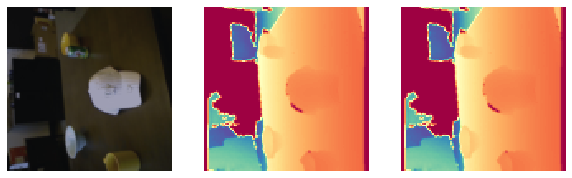

In [8]:
for i, batch in enumerate(train_loader):
    rgb_img = batch[0][0]
    depth_img = batch[1][0]
    visualize(rgb_img, depth_img, depth_img)
    break

In [10]:
estimator = DepthV3((100, 100))
estimator.load_state_dict(torch.load('models/depth_model_9_-1.053248668089509.pth'))
estimator.cuda();

In [11]:
lr = 0.00005
optimizer = optim.Adam(estimator.parameters(), lr=lr)
# optimizer = optim.SGD(estimator.parameters(), lr, momentum=0.9, weight_decay=1e-4)

lossGrad = GradientLoss()
lossNormal = NormalLoss()
berhu = BerHu()

In [21]:
start_epoch = 39
end_epoch = 70

In [13]:
# Reduce the learning rate
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.3

Train time 00h 00m 00s, Training started
Train time 00h 00m 08s Epoch 39 Batch 20 Frame 320
Avg_loss: -1.095284 loss_l2: 0.029168 loss_grad: -1.146028 loss_normal: 0.021576
Train time 00h 00m 15s Epoch 39 Batch 40 Frame 640
Avg_loss: -1.123272 loss_l2: 0.027205 loss_grad: -1.169121 loss_normal: 0.018644
Train time 00h 00m 23s Epoch 39 Batch 60 Frame 960
Avg_loss: -1.080607 loss_l2: 0.031875 loss_grad: -1.136485 loss_normal: 0.024003
Train time 00h 00m 31s Epoch 39 Batch 80 Frame 1280
Avg_loss: -1.086545 loss_l2: 0.037889 loss_grad: -1.147685 loss_normal: 0.023251
Train time 00h 00m 39s Epoch 39 Batch 100 Frame 1600
Avg_loss: -1.096356 loss_l2: 0.029943 loss_grad: -1.147492 loss_normal: 0.021192
Train time 00h 00m 47s Epoch 39 Batch 120 Frame 1920
Avg_loss: -1.095043 loss_l2: 0.031375 loss_grad: -1.148919 loss_normal: 0.022502
Train time 00h 00m 55s Epoch 39 Batch 140 Frame 2240
Avg_loss: -1.114930 loss_l2: 0.029209 loss_grad: -1.163278 loss_normal: 0.019139
Train time 00h 01m 03s Epoch

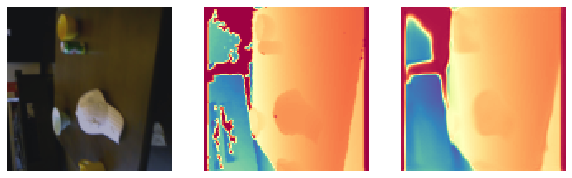

Train time 00h 01m 27s Epoch 39 Batch 220 Frame 3520
Avg_loss: -1.116943 loss_l2: 0.032035 loss_grad: -1.166805 loss_normal: 0.017827
Train time 00h 01m 35s Epoch 39 Batch 240 Frame 3840
Avg_loss: -1.118215 loss_l2: 0.026030 loss_grad: -1.163457 loss_normal: 0.019212
Train time 00h 01m 42s Epoch 39 Batch 260 Frame 4160
Avg_loss: -1.122342 loss_l2: 0.025280 loss_grad: -1.165890 loss_normal: 0.018268
Train time 00h 01m 50s Epoch 39 Batch 280 Frame 4480
Avg_loss: -1.117234 loss_l2: 0.027167 loss_grad: -1.164412 loss_normal: 0.020011
Train time 00h 01m 58s Epoch 39 Batch 300 Frame 4800
Avg_loss: -1.122533 loss_l2: 0.025579 loss_grad: -1.166628 loss_normal: 0.018517
Train time 00h 02m 06s Epoch 39 Batch 320 Frame 5120
Avg_loss: -1.127816 loss_l2: 0.025203 loss_grad: -1.171705 loss_normal: 0.018686
Train time 00h 02m 14s Epoch 39 Batch 340 Frame 5440
Avg_loss: -1.110038 loss_l2: 0.028530 loss_grad: -1.159041 loss_normal: 0.020474
Train time 00h 02m 21s Epoch 39 Batch 360 Frame 5760
Avg_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train time 00h 02m 37s Epoch 39 Batch 400 Frame 6400
Avg_loss: -1.126226 loss_l2: 0.024846 loss_grad: -1.171137 loss_normal: 0.020065


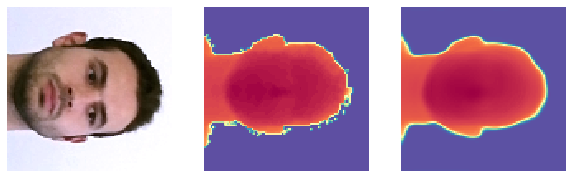

Train time 00h 02m 46s Epoch 39 Batch 420 Frame 6720
Avg_loss: -1.111577 loss_l2: 0.033079 loss_grad: -1.165521 loss_normal: 0.020866
Train time 00h 02m 53s Epoch 39 Batch 440 Frame 7040
Avg_loss: -1.080127 loss_l2: 0.034194 loss_grad: -1.137512 loss_normal: 0.023191
Train time 00h 03m 01s Epoch 39 Batch 460 Frame 7360
Avg_loss: -1.102743 loss_l2: 0.028081 loss_grad: -1.152650 loss_normal: 0.021826
Train time 00h 03m 09s Epoch 39 Batch 480 Frame 7680
Avg_loss: -1.123708 loss_l2: 0.025095 loss_grad: -1.167441 loss_normal: 0.018639
Train time 00h 03m 17s Epoch 39 Batch 500 Frame 8000
Avg_loss: -1.104129 loss_l2: 0.029394 loss_grad: -1.154207 loss_normal: 0.020684
Train time 00h 03m 25s Epoch 39 Batch 520 Frame 8320
Avg_loss: -1.134886 loss_l2: 0.024422 loss_grad: -1.176428 loss_normal: 0.017120
Train time 00h 03m 32s Epoch 39 Batch 540 Frame 8640
Avg_loss: -1.150841 loss_l2: 0.022773 loss_grad: -1.190443 loss_normal: 0.016829
Train time 00h 03m 40s Epoch 39 Batch 560 Frame 8960
Avg_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train time 00h 03m 56s Epoch 39 Batch 600 Frame 9600
Avg_loss: -1.145132 loss_l2: 0.022861 loss_grad: -1.184492 loss_normal: 0.016499


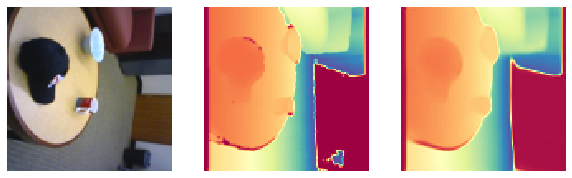

Train time 00h 04m 04s Epoch 39 Batch 620 Frame 9920
Avg_loss: -1.151280 loss_l2: 0.023398 loss_grad: -1.190351 loss_normal: 0.015673
Train time 00h 04m 12s Epoch 39 Batch 640 Frame 10240
Avg_loss: -1.141041 loss_l2: 0.025556 loss_grad: -1.182214 loss_normal: 0.015618
Train time 00h 04m 20s Epoch 39 Batch 660 Frame 10560
Avg_loss: -1.097554 loss_l2: 0.028927 loss_grad: -1.148634 loss_normal: 0.022153
Train time 00h 04m 28s Epoch 39 Batch 680 Frame 10880
Avg_loss: -1.103777 loss_l2: 0.028592 loss_grad: -1.153854 loss_normal: 0.021485
Train time 00h 04m 36s Epoch 39 Batch 700 Frame 11200
Avg_loss: -1.093794 loss_l2: 0.029830 loss_grad: -1.146272 loss_normal: 0.022648
Train time 00h 04m 44s Epoch 39 Batch 720 Frame 11520
Avg_loss: -1.107139 loss_l2: 0.026985 loss_grad: -1.155422 loss_normal: 0.021298
Train time 00h 04m 51s Epoch 39 Batch 740 Frame 11840
Avg_loss: -1.099466 loss_l2: 0.033382 loss_grad: -1.153291 loss_normal: 0.020444
Train time 00h 04m 59s Epoch 39 Batch 760 Frame 12160
Av

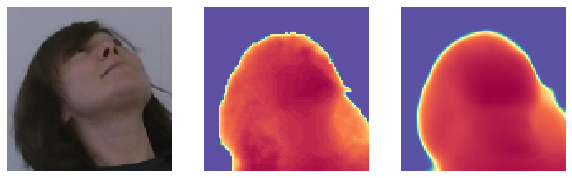

Train time 00h 05m 23s Epoch 39 Batch 820 Frame 13120
Avg_loss: -1.108869 loss_l2: 0.028105 loss_grad: -1.156865 loss_normal: 0.019891
Train time 00h 05m 31s Epoch 39 Batch 840 Frame 13440
Avg_loss: -1.093935 loss_l2: 0.028331 loss_grad: -1.145248 loss_normal: 0.022983
Train time 00h 05m 39s Epoch 39 Batch 860 Frame 13760
Avg_loss: -1.131285 loss_l2: 0.023839 loss_grad: -1.173556 loss_normal: 0.018432
Train time 00h 05m 47s Epoch 39 Batch 880 Frame 14080
Avg_loss: -1.094817 loss_l2: 0.034131 loss_grad: -1.152041 loss_normal: 0.023093
Train time 00h 05m 55s Epoch 39 Batch 900 Frame 14400
Avg_loss: -1.117749 loss_l2: 0.025866 loss_grad: -1.162783 loss_normal: 0.019168
Train time 00h 06m 02s Epoch 39 Batch 920 Frame 14720
Avg_loss: -1.106170 loss_l2: 0.028289 loss_grad: -1.155587 loss_normal: 0.021128
Train time 00h 06m 10s Epoch 39 Batch 940 Frame 15040
Avg_loss: -1.111450 loss_l2: 0.027490 loss_grad: -1.160290 loss_normal: 0.021350
Train time 00h 06m 18s Epoch 39 Batch 960 Frame 15360
A

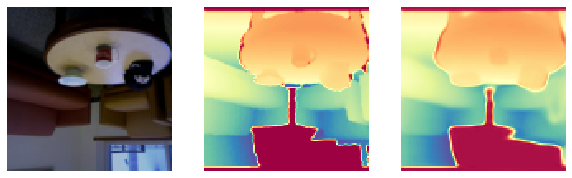

Train time 00h 06m 42s Epoch 39 Batch 1020 Frame 16320
Avg_loss: -1.117798 loss_l2: 0.025442 loss_grad: -1.163380 loss_normal: 0.020141
Train time 00h 06m 50s Epoch 39 Batch 1040 Frame 16640
Avg_loss: -1.122587 loss_l2: 0.028502 loss_grad: -1.170674 loss_normal: 0.019585
Train time 00h 06m 58s Epoch 39 Batch 1060 Frame 16960
Avg_loss: -1.102156 loss_l2: 0.028603 loss_grad: -1.152283 loss_normal: 0.021524
Train time 00h 07m 06s Epoch 39 Batch 1080 Frame 17280
Avg_loss: -1.110867 loss_l2: 0.027885 loss_grad: -1.158737 loss_normal: 0.019985
Train time 00h 07m 13s Epoch 39 Batch 1100 Frame 17600
Avg_loss: -1.105762 loss_l2: 0.031876 loss_grad: -1.158931 loss_normal: 0.021294
Train time 00h 07m 21s Epoch 39 Batch 1120 Frame 17920
Avg_loss: -1.121965 loss_l2: 0.026861 loss_grad: -1.168526 loss_normal: 0.019699
Train time 00h 07m 29s Epoch 39 Batch 1140 Frame 18240
Avg_loss: -1.115260 loss_l2: 0.028142 loss_grad: -1.162980 loss_normal: 0.019578
Train time 00h 07m 37s Epoch 39 Batch 1160 Frame

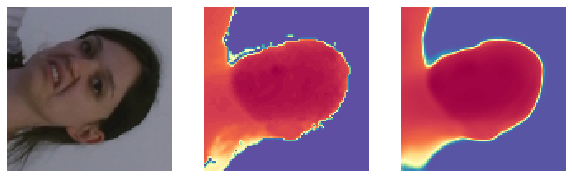

Train time 00h 08m 01s Epoch 39 Batch 1220 Frame 19520
Avg_loss: -1.128195 loss_l2: 0.026891 loss_grad: -1.173538 loss_normal: 0.018452
Train time 00h 08m 09s Epoch 39 Batch 1240 Frame 19840
Avg_loss: -1.111995 loss_l2: 0.028790 loss_grad: -1.161398 loss_normal: 0.020613
Train time 00h 08m 17s Epoch 39 Batch 1260 Frame 20160
Avg_loss: -1.136150 loss_l2: 0.025744 loss_grad: -1.178812 loss_normal: 0.016917
Train time 00h 08m 25s Epoch 39 Batch 1280 Frame 20480
Avg_loss: -1.099643 loss_l2: 0.032033 loss_grad: -1.152493 loss_normal: 0.020818
Train time 00h 08m 32s Epoch 39 Batch 1300 Frame 20800
Avg_loss: -1.118481 loss_l2: 0.029184 loss_grad: -1.166372 loss_normal: 0.018707
Train time 00h 08m 40s Epoch 39 Batch 1320 Frame 21120
Avg_loss: -1.116639 loss_l2: 0.028112 loss_grad: -1.164494 loss_normal: 0.019743
Train time 00h 08m 48s Epoch 39 Batch 1340 Frame 21440
Avg_loss: -1.112787 loss_l2: 0.028494 loss_grad: -1.160613 loss_normal: 0.019332
Train time 00h 08m 56s Epoch 39 Batch 1360 Frame

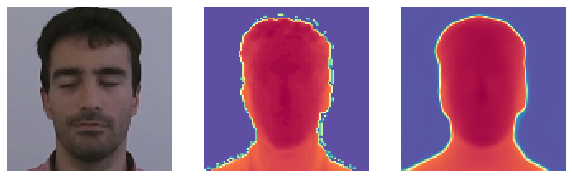

Train time 00h 09m 20s Epoch 39 Batch 1420 Frame 22720
Avg_loss: -1.095858 loss_l2: 0.028959 loss_grad: -1.147641 loss_normal: 0.022824
Train time 00h 09m 28s Epoch 39 Batch 1440 Frame 23040
Avg_loss: -1.101892 loss_l2: 0.033303 loss_grad: -1.156850 loss_normal: 0.021656
Train time 00h 09m 36s Epoch 39 Batch 1460 Frame 23360
Avg_loss: -1.088916 loss_l2: 0.032013 loss_grad: -1.144000 loss_normal: 0.023071
Train time 00h 09m 43s Epoch 39 Batch 1480 Frame 23680
Avg_loss: -1.097366 loss_l2: 0.029455 loss_grad: -1.148577 loss_normal: 0.021757
Train time 00h 09m 51s Epoch 39 Batch 1500 Frame 24000
Avg_loss: -1.101287 loss_l2: 0.034491 loss_grad: -1.157167 loss_normal: 0.021388
Train time 00h 09m 59s Epoch 39 Batch 1520 Frame 24320
Avg_loss: -1.102773 loss_l2: 0.030684 loss_grad: -1.154033 loss_normal: 0.020575
Train time 00h 10m 07s Epoch 39 Batch 1540 Frame 24640
Avg_loss: -1.112211 loss_l2: 0.026722 loss_grad: -1.159212 loss_normal: 0.020279
Train time 00h 10m 15s Epoch 39 Batch 1560 Frame

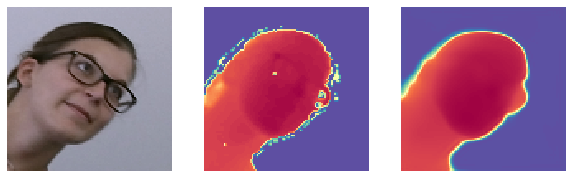

Train time 00h 10m 39s Epoch 39 Batch 1620 Frame 25920
Avg_loss: -1.090770 loss_l2: 0.035600 loss_grad: -1.149059 loss_normal: 0.022689
>>>>>>>>----------epoch 39 train finish---------<<<<<<<<


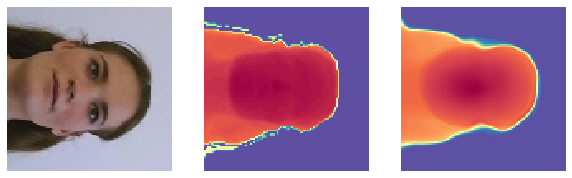

Test time 00h 11m 14s Epoch 39 TEST FINISH Avg loss: -1.0738794786686248
39 >>>>>>>>----------MODEL SAVED---------<<<<<<<<
Train time 00h 11m 15s, Training started
Train time 00h 11m 23s Epoch 40 Batch 20 Frame 320
Avg_loss: -1.111715 loss_l2: 0.029641 loss_grad: -1.161798 loss_normal: 0.020443
Train time 00h 11m 30s Epoch 40 Batch 40 Frame 640
Avg_loss: -1.106126 loss_l2: 0.029713 loss_grad: -1.156322 loss_normal: 0.020484
Train time 00h 11m 38s Epoch 40 Batch 60 Frame 960
Avg_loss: -1.123263 loss_l2: 0.025774 loss_grad: -1.167109 loss_normal: 0.018073
Train time 00h 11m 46s Epoch 40 Batch 80 Frame 1280
Avg_loss: -1.109696 loss_l2: 0.032605 loss_grad: -1.161784 loss_normal: 0.019483
Train time 00h 11m 54s Epoch 40 Batch 100 Frame 1600
Avg_loss: -1.109371 loss_l2: 0.026816 loss_grad: -1.155732 loss_normal: 0.019545
Train time 00h 12m 02s Epoch 40 Batch 120 Frame 1920
Avg_loss: -1.142165 loss_l2: 0.024840 loss_grad: -1.183525 loss_normal: 0.016520
Train time 00h 12m 10s Epoch 40 Batch 1

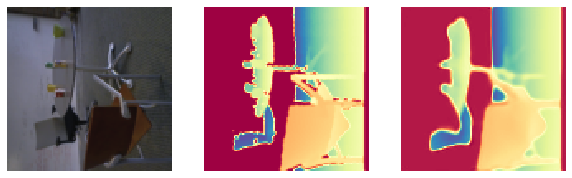

Train time 00h 12m 42s Epoch 40 Batch 220 Frame 3520
Avg_loss: -1.120445 loss_l2: 0.035177 loss_grad: -1.174804 loss_normal: 0.019183
Train time 00h 12m 50s Epoch 40 Batch 240 Frame 3840
Avg_loss: -1.112507 loss_l2: 0.027531 loss_grad: -1.161425 loss_normal: 0.021387
Train time 00h 12m 57s Epoch 40 Batch 260 Frame 4160
Avg_loss: -1.109565 loss_l2: 0.031225 loss_grad: -1.162022 loss_normal: 0.021233
Train time 00h 13m 05s Epoch 40 Batch 280 Frame 4480
Avg_loss: -1.139590 loss_l2: 0.023915 loss_grad: -1.180850 loss_normal: 0.017344
Train time 00h 13m 13s Epoch 40 Batch 300 Frame 4800
Avg_loss: -1.089543 loss_l2: 0.031501 loss_grad: -1.143986 loss_normal: 0.022942
Train time 00h 13m 21s Epoch 40 Batch 320 Frame 5120
Avg_loss: -1.105100 loss_l2: 0.028737 loss_grad: -1.154945 loss_normal: 0.021108
Train time 00h 13m 29s Epoch 40 Batch 340 Frame 5440
Avg_loss: -1.102805 loss_l2: 0.028669 loss_grad: -1.152909 loss_normal: 0.021435
Train time 00h 13m 37s Epoch 40 Batch 360 Frame 5760
Avg_loss:

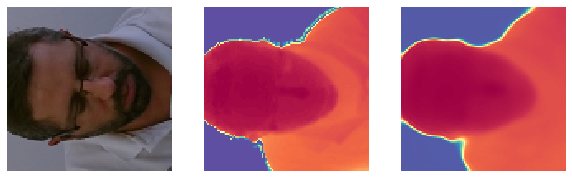

Train time 00h 14m 01s Epoch 40 Batch 420 Frame 6720
Avg_loss: -1.130678 loss_l2: 0.025285 loss_grad: -1.173651 loss_normal: 0.017688
Train time 00h 14m 09s Epoch 40 Batch 440 Frame 7040
Avg_loss: -1.081761 loss_l2: 0.031671 loss_grad: -1.137192 loss_normal: 0.023759
Train time 00h 14m 16s Epoch 40 Batch 460 Frame 7360
Avg_loss: -1.107596 loss_l2: 0.032268 loss_grad: -1.161743 loss_normal: 0.021879
Train time 00h 14m 24s Epoch 40 Batch 480 Frame 7680
Avg_loss: -1.115153 loss_l2: 0.029860 loss_grad: -1.165570 loss_normal: 0.020557
Train time 00h 14m 32s Epoch 40 Batch 500 Frame 8000
Avg_loss: -1.122187 loss_l2: 0.024416 loss_grad: -1.165923 loss_normal: 0.019320
Train time 00h 14m 40s Epoch 40 Batch 520 Frame 8320
Avg_loss: -1.110814 loss_l2: 0.028710 loss_grad: -1.159339 loss_normal: 0.019815
Train time 00h 14m 48s Epoch 40 Batch 540 Frame 8640
Avg_loss: -1.126903 loss_l2: 0.028170 loss_grad: -1.174023 loss_normal: 0.018949
Train time 00h 14m 56s Epoch 40 Batch 560 Frame 8960
Avg_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train time 00h 15m 11s Epoch 40 Batch 600 Frame 9600
Avg_loss: -1.101021 loss_l2: 0.036353 loss_grad: -1.159045 loss_normal: 0.021671


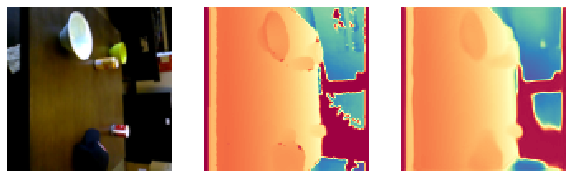

Train time 00h 15m 20s Epoch 40 Batch 620 Frame 9920
Avg_loss: -1.085250 loss_l2: 0.041769 loss_grad: -1.150000 loss_normal: 0.022981
Train time 00h 15m 27s Epoch 40 Batch 640 Frame 10240
Avg_loss: -1.098799 loss_l2: 0.030365 loss_grad: -1.151638 loss_normal: 0.022473
Train time 00h 15m 35s Epoch 40 Batch 660 Frame 10560
Avg_loss: -1.129496 loss_l2: 0.026824 loss_grad: -1.174570 loss_normal: 0.018249
Train time 00h 15m 43s Epoch 40 Batch 680 Frame 10880
Avg_loss: -1.136028 loss_l2: 0.023357 loss_grad: -1.176817 loss_normal: 0.017432
Train time 00h 15m 51s Epoch 40 Batch 700 Frame 11200
Avg_loss: -1.077650 loss_l2: 0.035764 loss_grad: -1.138408 loss_normal: 0.024995
Train time 00h 15m 59s Epoch 40 Batch 720 Frame 11520
Avg_loss: -1.102259 loss_l2: 0.030077 loss_grad: -1.153278 loss_normal: 0.020943
Train time 00h 16m 07s Epoch 40 Batch 740 Frame 11840
Avg_loss: -1.137934 loss_l2: 0.024531 loss_grad: -1.180124 loss_normal: 0.017659
Train time 00h 16m 14s Epoch 40 Batch 760 Frame 12160
Av

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train time 00h 16m 30s Epoch 40 Batch 800 Frame 12800
Avg_loss: -1.113139 loss_l2: 0.033819 loss_grad: -1.165552 loss_normal: 0.018594


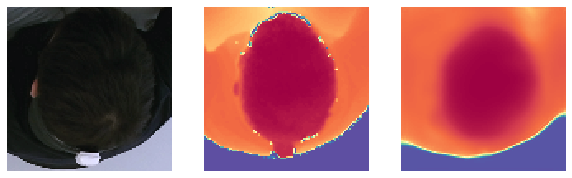

Train time 00h 16m 38s Epoch 40 Batch 820 Frame 13120
Avg_loss: -1.120669 loss_l2: 0.028399 loss_grad: -1.167864 loss_normal: 0.018795
Train time 00h 16m 46s Epoch 40 Batch 840 Frame 13440
Avg_loss: -1.104052 loss_l2: 0.031437 loss_grad: -1.157206 loss_normal: 0.021717
Train time 00h 16m 54s Epoch 40 Batch 860 Frame 13760
Avg_loss: -1.124694 loss_l2: 0.025967 loss_grad: -1.169917 loss_normal: 0.019256
Train time 00h 17m 02s Epoch 40 Batch 880 Frame 14080
Avg_loss: -1.094877 loss_l2: 0.035249 loss_grad: -1.152539 loss_normal: 0.022413
Train time 00h 17m 10s Epoch 40 Batch 900 Frame 14400
Avg_loss: -1.142855 loss_l2: 0.022064 loss_grad: -1.182665 loss_normal: 0.017746
Train time 00h 17m 18s Epoch 40 Batch 920 Frame 14720
Avg_loss: -1.114335 loss_l2: 0.026786 loss_grad: -1.161049 loss_normal: 0.019928
Train time 00h 17m 25s Epoch 40 Batch 940 Frame 15040
Avg_loss: -1.147104 loss_l2: 0.023765 loss_grad: -1.187147 loss_normal: 0.016279
Train time 00h 17m 33s Epoch 40 Batch 960 Frame 15360
A

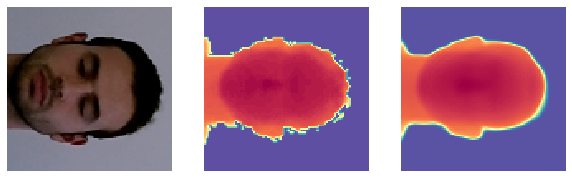

Train time 00h 17m 57s Epoch 40 Batch 1020 Frame 16320
Avg_loss: -1.093765 loss_l2: 0.033736 loss_grad: -1.149923 loss_normal: 0.022422
Train time 00h 18m 05s Epoch 40 Batch 1040 Frame 16640
Avg_loss: -1.125241 loss_l2: 0.029085 loss_grad: -1.173101 loss_normal: 0.018775
Train time 00h 18m 13s Epoch 40 Batch 1060 Frame 16960
Avg_loss: -1.080513 loss_l2: 0.040224 loss_grad: -1.144418 loss_normal: 0.023681
Train time 00h 18m 21s Epoch 40 Batch 1080 Frame 17280
Avg_loss: -1.094475 loss_l2: 0.030279 loss_grad: -1.146751 loss_normal: 0.021997
Train time 00h 18m 29s Epoch 40 Batch 1100 Frame 17600
Avg_loss: -1.104292 loss_l2: 0.032498 loss_grad: -1.158242 loss_normal: 0.021452
Train time 00h 18m 36s Epoch 40 Batch 1120 Frame 17920
Avg_loss: -1.108605 loss_l2: 0.029722 loss_grad: -1.159776 loss_normal: 0.021450
Train time 00h 18m 44s Epoch 40 Batch 1140 Frame 18240
Avg_loss: -1.089540 loss_l2: 0.034831 loss_grad: -1.146573 loss_normal: 0.022202
Train time 00h 18m 52s Epoch 40 Batch 1160 Frame

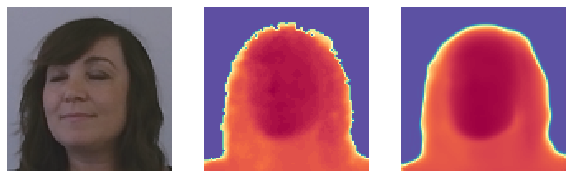

Train time 00h 19m 17s Epoch 40 Batch 1220 Frame 19520
Avg_loss: -1.121060 loss_l2: 0.027163 loss_grad: -1.167359 loss_normal: 0.019136
Train time 00h 19m 24s Epoch 40 Batch 1240 Frame 19840
Avg_loss: -1.123313 loss_l2: 0.029819 loss_grad: -1.171511 loss_normal: 0.018379
Train time 00h 19m 32s Epoch 40 Batch 1260 Frame 20160
Avg_loss: -1.109281 loss_l2: 0.028758 loss_grad: -1.158956 loss_normal: 0.020917
Train time 00h 19m 40s Epoch 40 Batch 1280 Frame 20480
Avg_loss: -1.122245 loss_l2: 0.028677 loss_grad: -1.169942 loss_normal: 0.019020
Train time 00h 19m 48s Epoch 40 Batch 1300 Frame 20800
Avg_loss: -1.121936 loss_l2: 0.029540 loss_grad: -1.170133 loss_normal: 0.018657
Train time 00h 19m 56s Epoch 40 Batch 1320 Frame 21120
Avg_loss: -1.108335 loss_l2: 0.031847 loss_grad: -1.160898 loss_normal: 0.020715
Train time 00h 20m 04s Epoch 40 Batch 1340 Frame 21440
Avg_loss: -1.092314 loss_l2: 0.041444 loss_grad: -1.154784 loss_normal: 0.021027
Train time 00h 20m 11s Epoch 40 Batch 1360 Frame

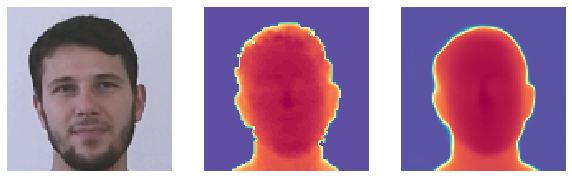

Train time 00h 20m 35s Epoch 40 Batch 1420 Frame 22720
Avg_loss: -1.107962 loss_l2: 0.026893 loss_grad: -1.156413 loss_normal: 0.021558
Train time 00h 20m 43s Epoch 40 Batch 1440 Frame 23040
Avg_loss: -1.117987 loss_l2: 0.028524 loss_grad: -1.165286 loss_normal: 0.018775
Train time 00h 20m 51s Epoch 40 Batch 1460 Frame 23360
Avg_loss: -1.109511 loss_l2: 0.029024 loss_grad: -1.159025 loss_normal: 0.020490
Train time 00h 20m 59s Epoch 40 Batch 1480 Frame 23680
Avg_loss: -1.082979 loss_l2: 0.038131 loss_grad: -1.145211 loss_normal: 0.024102
Train time 00h 21m 07s Epoch 40 Batch 1500 Frame 24000
Avg_loss: -1.111471 loss_l2: 0.025909 loss_grad: -1.158540 loss_normal: 0.021159
Train time 00h 21m 14s Epoch 40 Batch 1520 Frame 24320
Avg_loss: -1.115774 loss_l2: 0.025977 loss_grad: -1.160668 loss_normal: 0.018917
Train time 00h 21m 22s Epoch 40 Batch 1540 Frame 24640
Avg_loss: -1.142775 loss_l2: 0.022072 loss_grad: -1.181638 loss_normal: 0.016791
Train time 00h 21m 30s Epoch 40 Batch 1560 Frame

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train time 00h 21m 46s Epoch 40 Batch 1600 Frame 25600
Avg_loss: -1.073636 loss_l2: 0.038165 loss_grad: -1.136106 loss_normal: 0.024305


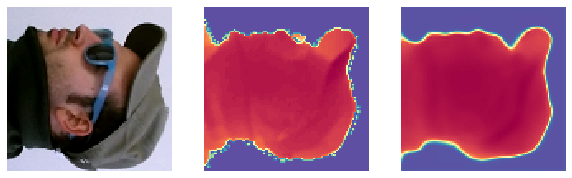

Train time 00h 21m 54s Epoch 40 Batch 1620 Frame 25920
Avg_loss: -1.129396 loss_l2: 0.025013 loss_grad: -1.173091 loss_normal: 0.018682
>>>>>>>>----------epoch 40 train finish---------<<<<<<<<


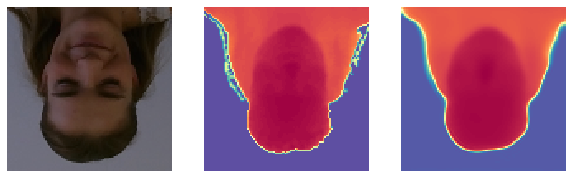

Test time 00h 22m 29s Epoch 40 TEST FINISH Avg loss: -1.076169682497328
40 >>>>>>>>----------MODEL SAVED---------<<<<<<<<
Train time 00h 22m 29s, Training started
Train time 00h 22m 38s Epoch 41 Batch 20 Frame 320
Avg_loss: -1.120419 loss_l2: 0.024312 loss_grad: -1.163905 loss_normal: 0.019174
Train time 00h 22m 46s Epoch 41 Batch 40 Frame 640
Avg_loss: -1.143645 loss_l2: 0.024146 loss_grad: -1.184742 loss_normal: 0.016951
Train time 00h 22m 53s Epoch 41 Batch 60 Frame 960
Avg_loss: -1.108531 loss_l2: 0.027322 loss_grad: -1.157275 loss_normal: 0.021422
Train time 00h 23m 01s Epoch 41 Batch 80 Frame 1280
Avg_loss: -1.117099 loss_l2: 0.027219 loss_grad: -1.162621 loss_normal: 0.018303
Train time 00h 23m 09s Epoch 41 Batch 100 Frame 1600
Avg_loss: -1.144741 loss_l2: 0.024391 loss_grad: -1.185443 loss_normal: 0.016311
Train time 00h 23m 17s Epoch 41 Batch 120 Frame 1920
Avg_loss: -1.120448 loss_l2: 0.029748 loss_grad: -1.169893 loss_normal: 0.019696
Train time 00h 23m 25s Epoch 41 Batch 14

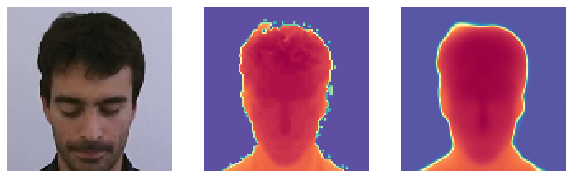

Train time 00h 23m 57s Epoch 41 Batch 220 Frame 3520
Avg_loss: -1.110571 loss_l2: 0.028389 loss_grad: -1.159420 loss_normal: 0.020460
Train time 00h 24m 04s Epoch 41 Batch 240 Frame 3840
Avg_loss: -1.120494 loss_l2: 0.026298 loss_grad: -1.166096 loss_normal: 0.019303
Train time 00h 24m 12s Epoch 41 Batch 260 Frame 4160
Avg_loss: -1.104352 loss_l2: 0.030037 loss_grad: -1.155287 loss_normal: 0.020898
Train time 00h 24m 20s Epoch 41 Batch 280 Frame 4480
Avg_loss: -1.127623 loss_l2: 0.026070 loss_grad: -1.172142 loss_normal: 0.018448
Train time 00h 24m 28s Epoch 41 Batch 300 Frame 4800
Avg_loss: -1.117162 loss_l2: 0.031582 loss_grad: -1.167583 loss_normal: 0.018839
Train time 00h 24m 36s Epoch 41 Batch 320 Frame 5120
Avg_loss: -1.126433 loss_l2: 0.027243 loss_grad: -1.171949 loss_normal: 0.018273
Train time 00h 24m 43s Epoch 41 Batch 340 Frame 5440
Avg_loss: -1.135975 loss_l2: 0.024155 loss_grad: -1.177298 loss_normal: 0.017169
Train time 00h 24m 51s Epoch 41 Batch 360 Frame 5760
Avg_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train time 00h 25m 07s Epoch 41 Batch 400 Frame 6400
Avg_loss: -1.096400 loss_l2: 0.028708 loss_grad: -1.147558 loss_normal: 0.022450


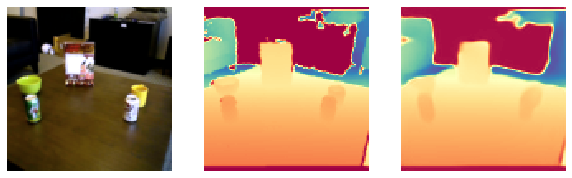

Train time 00h 25m 15s Epoch 41 Batch 420 Frame 6720
Avg_loss: -1.137623 loss_l2: 0.025351 loss_grad: -1.180490 loss_normal: 0.017516
Train time 00h 25m 23s Epoch 41 Batch 440 Frame 7040
Avg_loss: -1.133134 loss_l2: 0.024340 loss_grad: -1.175530 loss_normal: 0.018055
Train time 00h 25m 31s Epoch 41 Batch 460 Frame 7360
Avg_loss: -1.147212 loss_l2: 0.023480 loss_grad: -1.187342 loss_normal: 0.016650
Train time 00h 25m 39s Epoch 41 Batch 480 Frame 7680
Avg_loss: -1.095296 loss_l2: 0.029956 loss_grad: -1.149073 loss_normal: 0.023821
Train time 00h 25m 47s Epoch 41 Batch 500 Frame 8000
Avg_loss: -1.131129 loss_l2: 0.028725 loss_grad: -1.176894 loss_normal: 0.017039
Train time 00h 25m 54s Epoch 41 Batch 520 Frame 8320
Avg_loss: -1.132845 loss_l2: 0.026158 loss_grad: -1.176381 loss_normal: 0.017378
Train time 00h 26m 02s Epoch 41 Batch 540 Frame 8640
Avg_loss: -1.116243 loss_l2: 0.026317 loss_grad: -1.161633 loss_normal: 0.019073
Train time 00h 26m 10s Epoch 41 Batch 560 Frame 8960
Avg_loss:

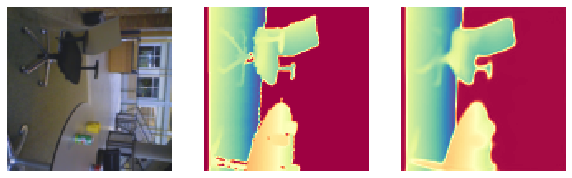

Train time 00h 26m 34s Epoch 41 Batch 620 Frame 9920
Avg_loss: -1.131814 loss_l2: 0.026228 loss_grad: -1.177013 loss_normal: 0.018971
Train time 00h 26m 42s Epoch 41 Batch 640 Frame 10240
Avg_loss: -1.106127 loss_l2: 0.035241 loss_grad: -1.161680 loss_normal: 0.020313
Train time 00h 26m 50s Epoch 41 Batch 660 Frame 10560
Avg_loss: -1.104435 loss_l2: 0.027773 loss_grad: -1.154466 loss_normal: 0.022257
Train time 00h 26m 57s Epoch 41 Batch 680 Frame 10880
Avg_loss: -1.100175 loss_l2: 0.028726 loss_grad: -1.150335 loss_normal: 0.021434
Train time 00h 27m 05s Epoch 41 Batch 700 Frame 11200
Avg_loss: -1.122397 loss_l2: 0.027899 loss_grad: -1.168379 loss_normal: 0.018083
Train time 00h 27m 13s Epoch 41 Batch 720 Frame 11520
Avg_loss: -1.137071 loss_l2: 0.023390 loss_grad: -1.177785 loss_normal: 0.017324
Train time 00h 27m 21s Epoch 41 Batch 740 Frame 11840
Avg_loss: -1.135095 loss_l2: 0.028381 loss_grad: -1.179996 loss_normal: 0.016520
Train time 00h 27m 29s Epoch 41 Batch 760 Frame 12160
Av

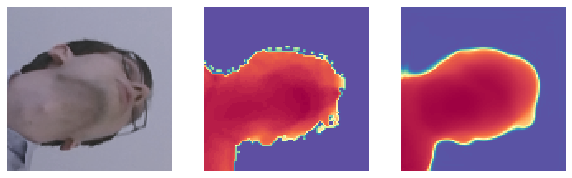

Train time 00h 27m 54s Epoch 41 Batch 820 Frame 13120
Avg_loss: -1.117665 loss_l2: 0.028725 loss_grad: -1.165587 loss_normal: 0.019197
Train time 00h 28m 01s Epoch 41 Batch 840 Frame 13440
Avg_loss: -1.125937 loss_l2: 0.024222 loss_grad: -1.169091 loss_normal: 0.018932
Train time 00h 28m 09s Epoch 41 Batch 860 Frame 13760
Avg_loss: -1.138454 loss_l2: 0.025168 loss_grad: -1.181730 loss_normal: 0.018109
Train time 00h 28m 17s Epoch 41 Batch 880 Frame 14080
Avg_loss: -1.140249 loss_l2: 0.023198 loss_grad: -1.179818 loss_normal: 0.016371
Train time 00h 28m 25s Epoch 41 Batch 900 Frame 14400
Avg_loss: -1.120791 loss_l2: 0.026645 loss_grad: -1.166297 loss_normal: 0.018861
Train time 00h 28m 33s Epoch 41 Batch 920 Frame 14720
Avg_loss: -1.123379 loss_l2: 0.025403 loss_grad: -1.167155 loss_normal: 0.018372
Train time 00h 28m 41s Epoch 41 Batch 940 Frame 15040
Avg_loss: -1.153548 loss_l2: 0.021228 loss_grad: -1.189784 loss_normal: 0.015007
Train time 00h 28m 48s Epoch 41 Batch 960 Frame 15360
A

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train time 00h 29m 04s Epoch 41 Batch 1000 Frame 16000
Avg_loss: -1.115865 loss_l2: 0.027720 loss_grad: -1.162283 loss_normal: 0.018697


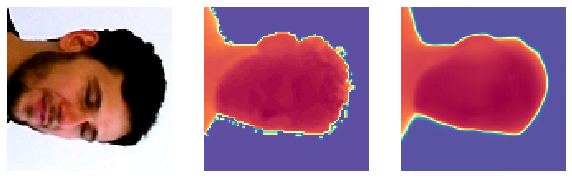

Train time 00h 29m 13s Epoch 41 Batch 1020 Frame 16320
Avg_loss: -1.104378 loss_l2: 0.028591 loss_grad: -1.153771 loss_normal: 0.020802
Train time 00h 29m 20s Epoch 41 Batch 1040 Frame 16640
Avg_loss: -1.131658 loss_l2: 0.024179 loss_grad: -1.173990 loss_normal: 0.018153
Train time 00h 29m 28s Epoch 41 Batch 1060 Frame 16960
Avg_loss: -1.120903 loss_l2: 0.028465 loss_grad: -1.169613 loss_normal: 0.020244
Train time 00h 29m 36s Epoch 41 Batch 1080 Frame 17280
Avg_loss: -1.130318 loss_l2: 0.027184 loss_grad: -1.176766 loss_normal: 0.019264
Train time 00h 29m 44s Epoch 41 Batch 1100 Frame 17600
Avg_loss: -1.148992 loss_l2: 0.025610 loss_grad: -1.190935 loss_normal: 0.016333
Train time 00h 29m 52s Epoch 41 Batch 1120 Frame 17920
Avg_loss: -1.154209 loss_l2: 0.022661 loss_grad: -1.192779 loss_normal: 0.015909
Train time 00h 30m 00s Epoch 41 Batch 1140 Frame 18240
Avg_loss: -1.132282 loss_l2: 0.024801 loss_grad: -1.175690 loss_normal: 0.018606
Train time 00h 30m 07s Epoch 41 Batch 1160 Frame

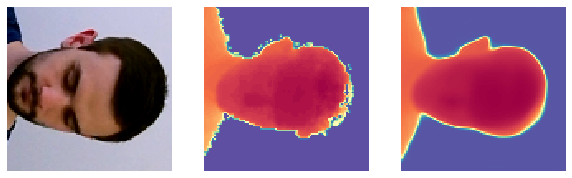

Train time 00h 30m 31s Epoch 41 Batch 1220 Frame 19520
Avg_loss: -1.123560 loss_l2: 0.026667 loss_grad: -1.169384 loss_normal: 0.019157
Train time 00h 30m 39s Epoch 41 Batch 1240 Frame 19840
Avg_loss: -1.112635 loss_l2: 0.026081 loss_grad: -1.160113 loss_normal: 0.021396
Train time 00h 30m 47s Epoch 41 Batch 1260 Frame 20160
Avg_loss: -1.109700 loss_l2: 0.033871 loss_grad: -1.163999 loss_normal: 0.020429
Train time 00h 30m 55s Epoch 41 Batch 1280 Frame 20480
Avg_loss: -1.116468 loss_l2: 0.027013 loss_grad: -1.163723 loss_normal: 0.020242
Train time 00h 31m 03s Epoch 41 Batch 1300 Frame 20800
Avg_loss: -1.107268 loss_l2: 0.026722 loss_grad: -1.154176 loss_normal: 0.020186
Train time 00h 31m 11s Epoch 41 Batch 1320 Frame 21120
Avg_loss: -1.136202 loss_l2: 0.026958 loss_grad: -1.180434 loss_normal: 0.017273
Train time 00h 31m 18s Epoch 41 Batch 1340 Frame 21440
Avg_loss: -1.112381 loss_l2: 0.029872 loss_grad: -1.161467 loss_normal: 0.019214
Train time 00h 31m 26s Epoch 41 Batch 1360 Frame

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train time 00h 31m 42s Epoch 41 Batch 1400 Frame 22400
Avg_loss: -1.122864 loss_l2: 0.026245 loss_grad: -1.167967 loss_normal: 0.018858


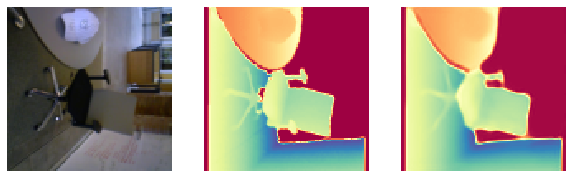

Train time 00h 31m 50s Epoch 41 Batch 1420 Frame 22720
Avg_loss: -1.111868 loss_l2: 0.027165 loss_grad: -1.159335 loss_normal: 0.020303
Train time 00h 31m 58s Epoch 41 Batch 1440 Frame 23040
Avg_loss: -1.104369 loss_l2: 0.029380 loss_grad: -1.155386 loss_normal: 0.021637
Train time 00h 32m 06s Epoch 41 Batch 1460 Frame 23360
Avg_loss: -1.149593 loss_l2: 0.023879 loss_grad: -1.188471 loss_normal: 0.014999
Train time 00h 32m 14s Epoch 41 Batch 1480 Frame 23680
Avg_loss: -1.102692 loss_l2: 0.027015 loss_grad: -1.150952 loss_normal: 0.021245
Train time 00h 32m 22s Epoch 41 Batch 1500 Frame 24000
Avg_loss: -1.097656 loss_l2: 0.029286 loss_grad: -1.149987 loss_normal: 0.023046
Train time 00h 32m 29s Epoch 41 Batch 1520 Frame 24320
Avg_loss: -1.122221 loss_l2: 0.031086 loss_grad: -1.172133 loss_normal: 0.018826
Train time 00h 32m 37s Epoch 41 Batch 1540 Frame 24640
Avg_loss: -1.122102 loss_l2: 0.026144 loss_grad: -1.168488 loss_normal: 0.020242
Train time 00h 32m 45s Epoch 41 Batch 1560 Frame

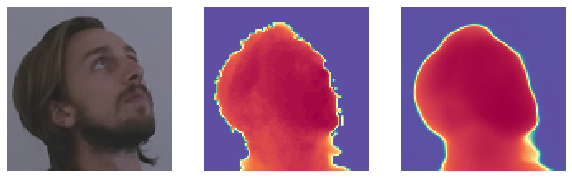

Train time 00h 33m 09s Epoch 41 Batch 1620 Frame 25920
Avg_loss: -1.111301 loss_l2: 0.032220 loss_grad: -1.163895 loss_normal: 0.020374
>>>>>>>>----------epoch 41 train finish---------<<<<<<<<


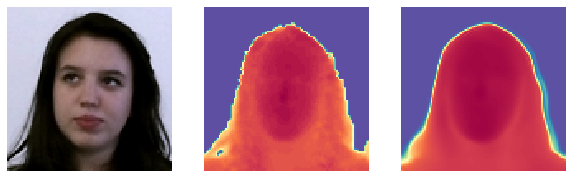

Test time 00h 33m 44s Epoch 41 TEST FINISH Avg loss: -1.0750395276329734
41 >>>>>>>>----------MODEL SAVED---------<<<<<<<<
Train time 00h 33m 45s, Training started
Train time 00h 33m 53s Epoch 42 Batch 20 Frame 320
Avg_loss: -1.129005 loss_l2: 0.023144 loss_grad: -1.170827 loss_normal: 0.018678
Train time 00h 34m 01s Epoch 42 Batch 40 Frame 640
Avg_loss: -1.119665 loss_l2: 0.026009 loss_grad: -1.165676 loss_normal: 0.020001
Train time 00h 34m 09s Epoch 42 Batch 60 Frame 960
Avg_loss: -1.129188 loss_l2: 0.025924 loss_grad: -1.173103 loss_normal: 0.017992
Train time 00h 34m 16s Epoch 42 Batch 80 Frame 1280
Avg_loss: -1.094857 loss_l2: 0.030283 loss_grad: -1.148155 loss_normal: 0.023015


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/opt/anaconda3/lib/python3.7/

KeyboardInterrupt: 

In [22]:
st_time = time.time()
for epoch in range(start_epoch, end_epoch):
    mess = 'Train time {0}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)) + ', ' + 'Training started')
    print(mess)
    
    train_count = 0
    loss_avg = 0.0
    loss_berhu_avg= 0.0
    loss_normal_avg = 0.0
    loss_grad_avg = 0.0
    train_loss_avg = 0.0
    estimator.train()
    optimizer.zero_grad()
    
    for i, data in enumerate(train_loader):
        rgbs, depths = data
        rgbs, depths = rgbs.float().cuda(), depths.float().cuda()
        
        pred_depths = estimator(rgbs)
        
        loss_Berhu = berhu(pred_depths, depths) 
        loss_grad = lossGrad(pred_depths, depths) 
        loss_normal = lossNormal(pred_depths, depths) 
        total_loss = loss_Berhu + loss_normal + loss_grad
        
        total_loss.backward()
        

        loss_avg = total_loss.item()
        loss_berhu_avg = loss_Berhu.item()
        loss_normal_avg = loss_normal.item()
        loss_grad_avg = loss_grad.item()
        train_loss_avg = total_loss.item()
        train_count += batch_size
        
        optimizer.step()
        optimizer.zero_grad()
        
        if train_count % (batch_size * 20) == 0:
            mess = 'Train time {0} Epoch {1} Batch {2} Frame {3}\nAvg_loss: {4:.6f} loss_l2: {5:.6f} loss_grad: {6:.6f} loss_normal: {7:.6f}'.format(
                                time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), 
                                epoch, int(train_count / batch_size), 
                                train_count, 
                                loss_avg, 
                                loss_berhu_avg, 
                                loss_grad_avg, 
                                loss_normal_avg)
            print(mess)
        
        if train_count != 0 and train_count % ( batch_size * 200) == 0:                    
            rgb_img = rgbs[0].cpu().detach()
            depth_img = depths[0].cpu().detach()
            pred_depth_img = pred_depths[0].cpu().detach()
            visualize(rgb_img, depth_img, pred_depth_img)
            
            torch.save(estimator.state_dict(), 'models/depth_model_current.pth')
        
    print('>>>>>>>>----------epoch {0} train finish---------<<<<<<<<'.format(epoch))
    
    test_loss = 0.0
    test_count = 0
    estimator.eval()
    plot = True
    
    for j, data in enumerate(val_loader):
        rgbs, depths = data
        rgbs, depths = rgbs.float().cuda(), depths.float().cuda()
        
        pred_depths = estimator(rgbs)
        
        loss_Berhu = berhu(pred_depths, depths) 
        loss_grad = lossGrad(pred_depths, depths) 
        loss_normal = lossNormal(pred_depths, depths) 
        total_loss = loss_Berhu + loss_normal + loss_grad
        
        test_loss += total_loss.item()
        test_count += 1
    
    
        
        if plot:
            rgb_img = rgbs[0].cpu().detach()
            depth_img = depths[0].cpu().detach()
            pred_depth_img = pred_depths[0].cpu().detach()
            visualize(rgb_img, depth_img, pred_depth_img)
            plot = False
            
    test_loss = test_loss / test_count    
    mess = 'Test time {0} Epoch {1} TEST FINISH Avg loss: {2}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), epoch, test_loss)
    print(mess)
        
    torch.save(estimator.state_dict(), 'models/depth_model_{0}_{1}.pth'.format(epoch, test_loss))
    print(epoch, '>>>>>>>>----------MODEL SAVED---------<<<<<<<<')
    
    

# Evaluate

In [23]:
class FaceDataset(Dataset):
    def __init__(self, data_root):   
        self.samples = []
        for img in os.listdir(data_root):
            if ".ipynb" not in img:
                img_path = os.path.join(data_root, img)
                self.samples.append(img_path)
                    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img = Image.open(self.samples[idx])

        img = TF.resize(img, 100)
        img = TF.center_crop(img, 100)
        img = TF.to_tensor(img)
        
        img = TF.normalize(img, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        
        return img

In [24]:
face_dataset = FaceDataset("input/content")
face_loader = DataLoader(face_dataset, batch_size=1, shuffle=True, num_workers=2)

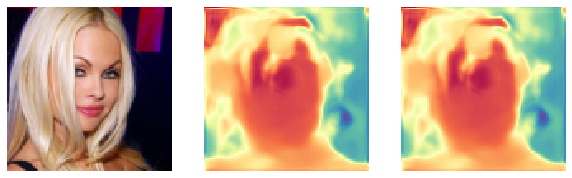

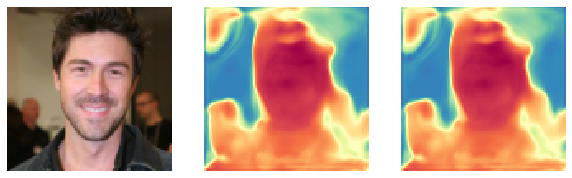

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


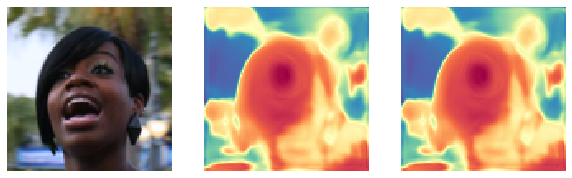

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


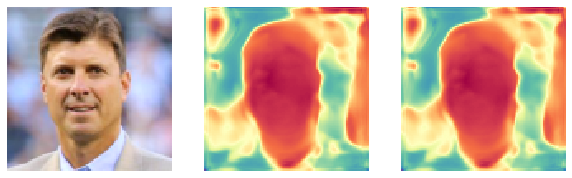

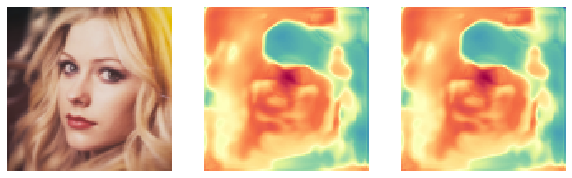

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


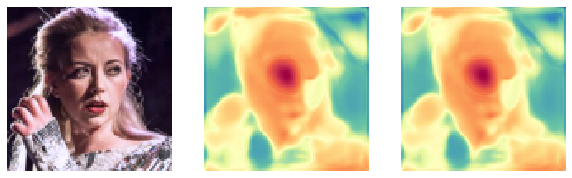

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


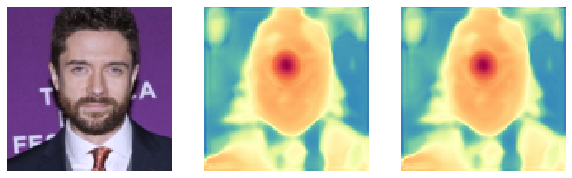

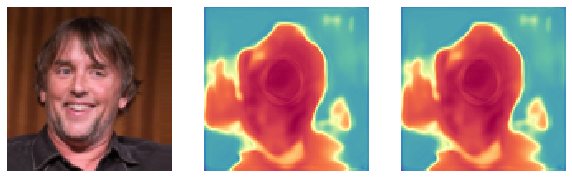

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


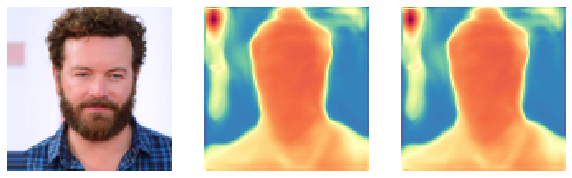

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


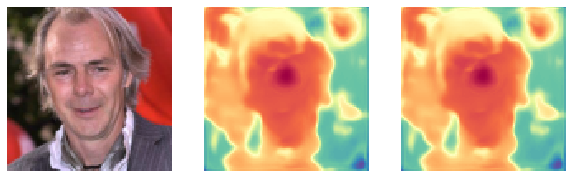

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


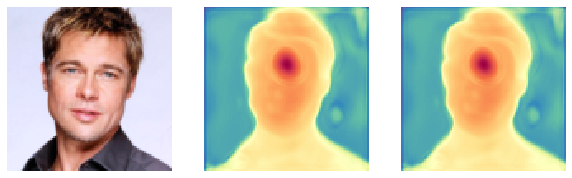

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


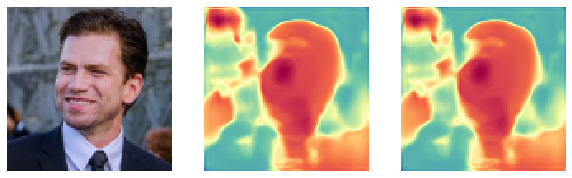

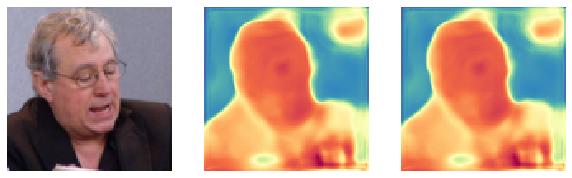

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


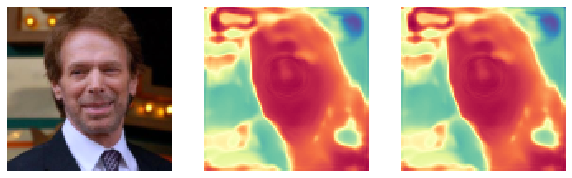

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


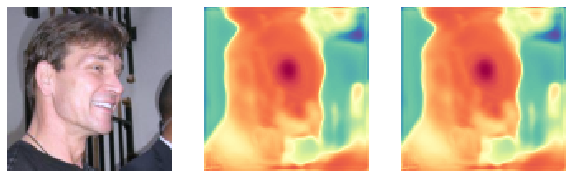

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


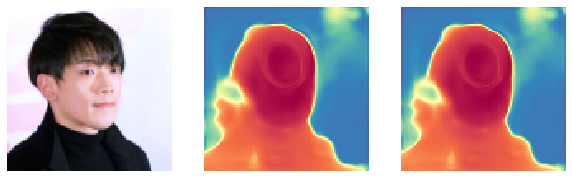

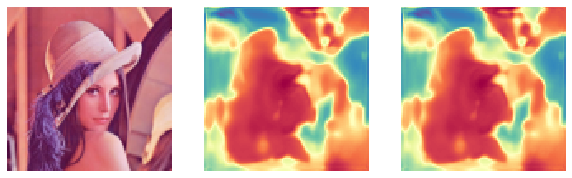

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


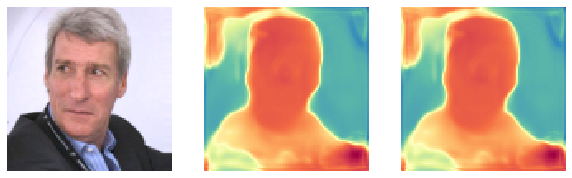

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


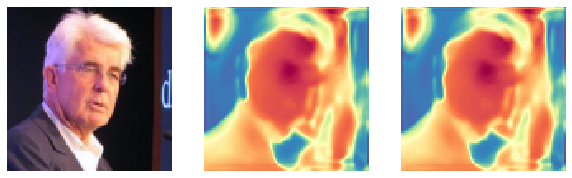

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


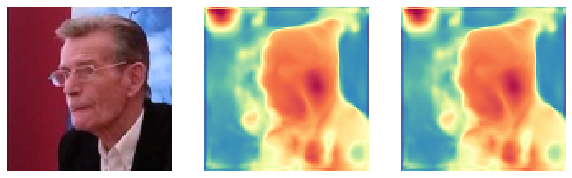

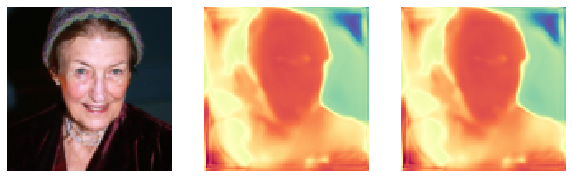

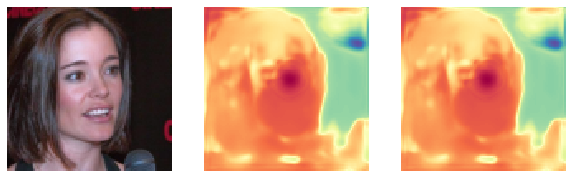

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


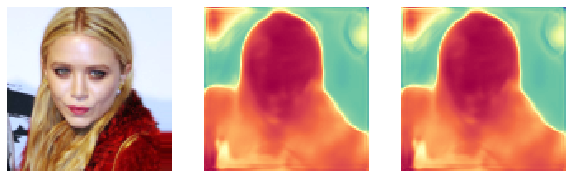

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


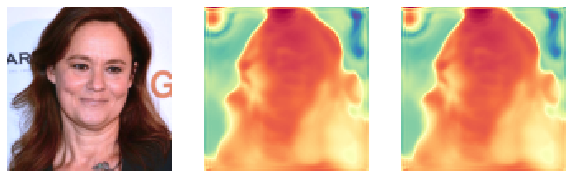

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


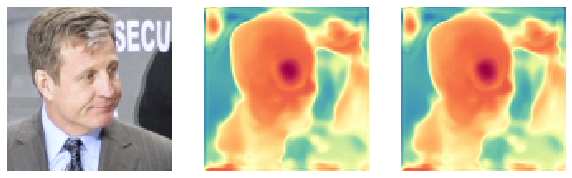

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


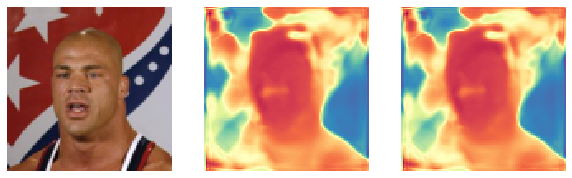

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


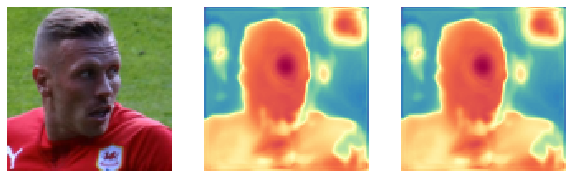

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


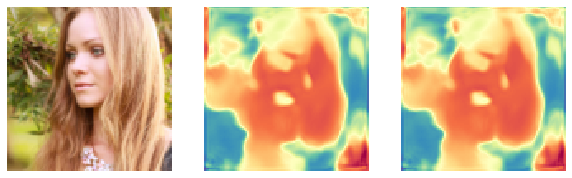

In [25]:
for i, img in enumerate(face_loader):
    img = img.cuda()
    pred_depth = estimator(img)
    rgb_img = img[0].cpu().detach()
    pred_depth_img = pred_depth[0].cpu().detach()
    visualize(rgb_img, pred_depth_img, pred_depth_img)

# Train on scene and face RGBD datasets

# Train on face RGBD only 

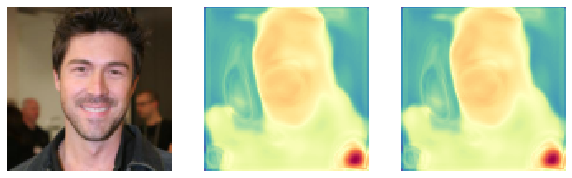

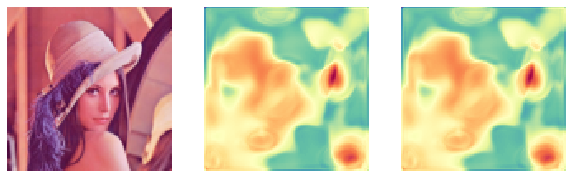

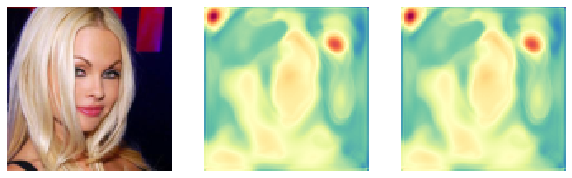

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


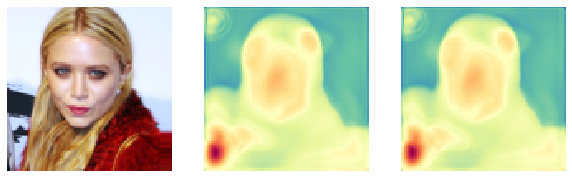

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


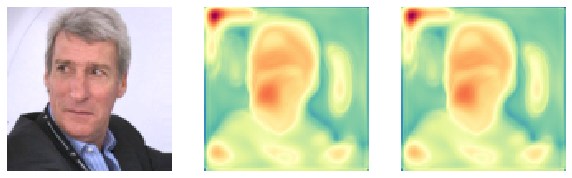

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


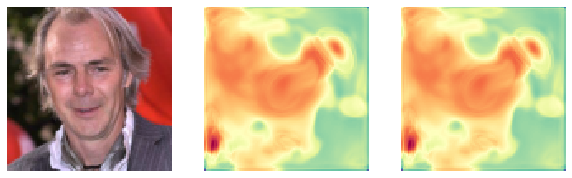

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


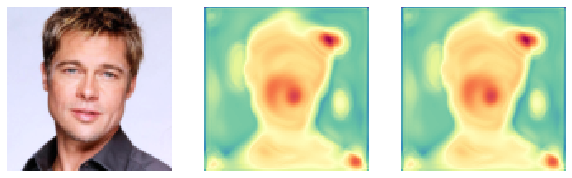

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


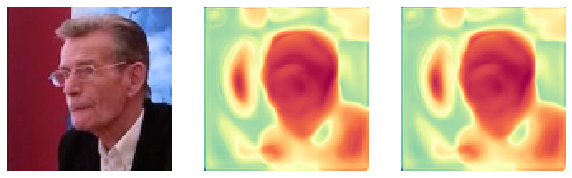

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


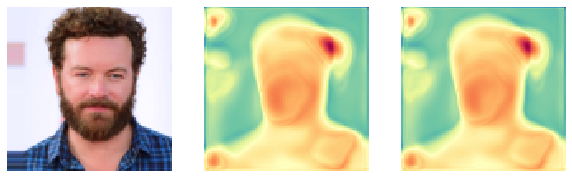

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


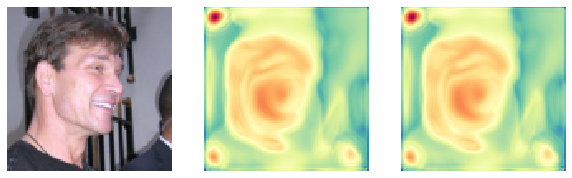

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


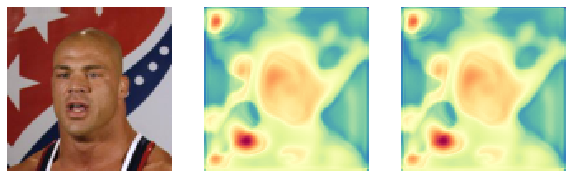

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


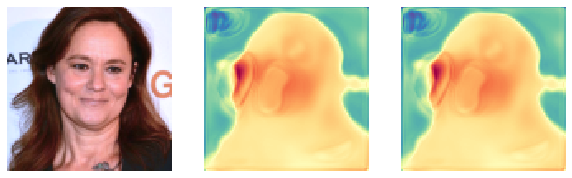

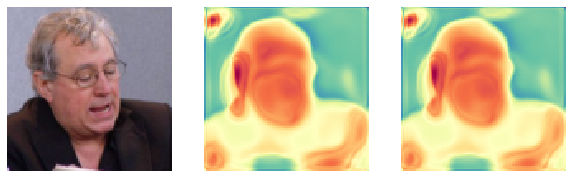

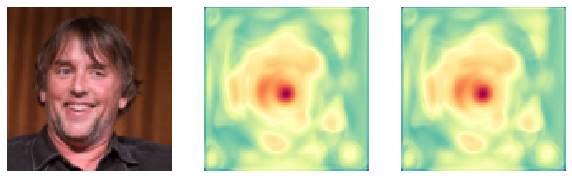

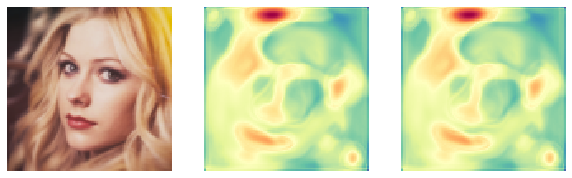

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


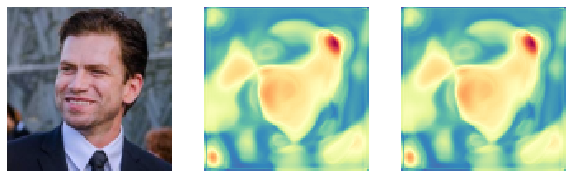

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


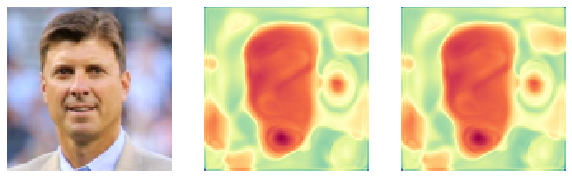

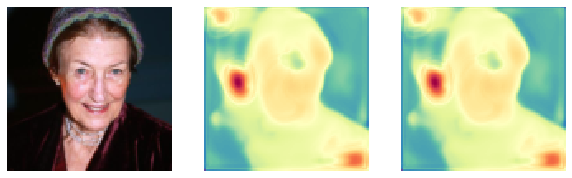

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


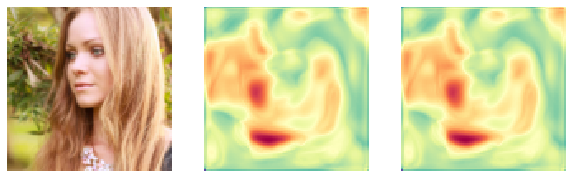

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


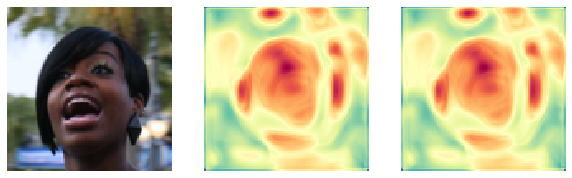

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


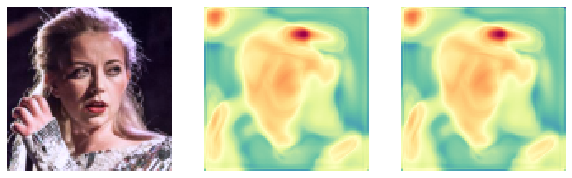

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


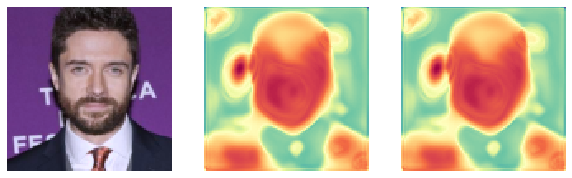

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


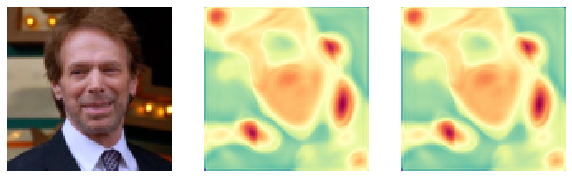

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


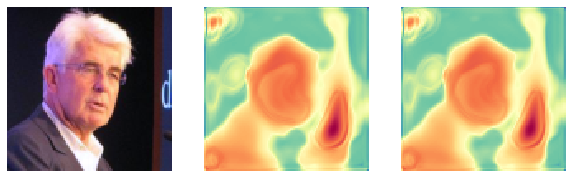

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


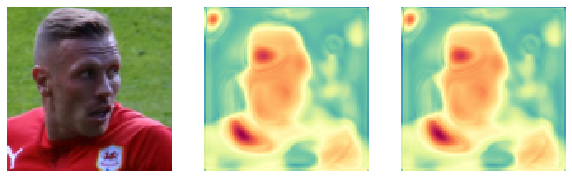

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


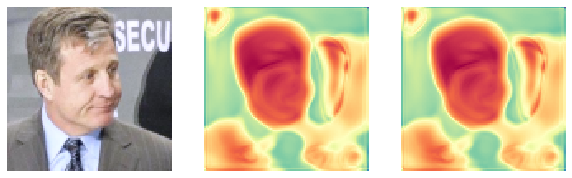

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


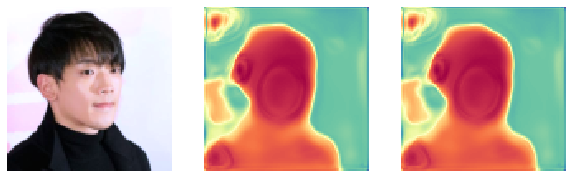

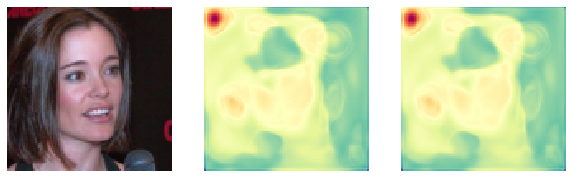

In [29]:
for i, img in enumerate(face_loader):
    img = img.cuda()
    pred_depth = estimator(img)
    rgb_img = img[0].cpu().detach()
    pred_depth_img = pred_depth[0].cpu().detach()
    visualize(rgb_img, pred_depth_img, pred_depth_img)